### Example of Further Fine-tuning Experiments - Applying SMOTE-Tomek

Model G3.3, ISIC 2017 dataset, ResNet-50	base model, Categorical Crossentropy loss function,  batch size =	32, lr = 1e-5, augmentation = No, SMOTE-Tomek = Yes, Top 64 layers trainable


In [ ]:
#!pip install imbalanced-learn

In [ ]:
#import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
import random

#support for SMOTE-Tomek
from imblearn.combine import SMOTETomek

In [ ]:
#setup for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#general configuration
IMG_SIZE = (224, 224)
NUM_CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 20 #early fine-tuning
LR = 1e-5
LOSS ='categorical_crossentropy'

In [ ]:
#............ Utility Functions ............

#extracts downloaded data from zip file format
def extract_zip(filename, target_path="."):
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(target_path)

#loads and preprocesses the label data (target)
def load_and_process_labels(csv_path):
    df = pd.read_csv(csv_path)
    df['new_image_id'] = df['image_id'] + ".jpg"
    df['id'] = df['melanoma'].apply(lambda x: 'mel' if x != 0.0 else 'no') + \
               df['seborrheic_keratosis'].apply(lambda x: 'seb' if x != 0.0 else 'no')
    df['label'] = df['id'].apply(lambda x: 0 if x == 'nono' else 2 if x == 'melno' else 1)
    return df

#determine the distribution of classes in the dataset
def show_class_distribution(y, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)
    class_labels = ['Benign (0)', 'SK (1)', 'Melanoma (2)']

    print(f"\n{title}:")
    for label, count in zip(unique, counts):
        print(f"  Class {label} ({class_labels[label]}): {count} samples")

#apply fixed augmentations to underrepresented classes
def augment_image_fixed(img, mode):
    if mode == 'flip_lr':
        img = tf.image.flip_left_right(img)
    elif mode == 'flip_ud':
        img = tf.image.flip_up_down(img)
    elif mode == 'rot90':
        img = tf.image.rot90(img, k=1)
    elif mode == 'rot180':
        img = tf.image.rot90(img, k=2)
    return img

#load the image dataset and preprocess e.g. correct color format, reszie, map labels
def load_images(df, img_dir):
    X, y = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['new_image_id'])
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is None:
                continue  # skip corrupted image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X.append(img.astype('float32') / 255.0)
            y.append(row['label'])
    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {len(X)} images from {img_dir}")
    return X, y

#build the model, adding custom top layer
def build_resnet50_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    #freeze all layers by default
    base_model.trainable = False

    #unfreeze the top 64 layers (i.e., last 64 layers in the model)
    for layer in base_model.layers[-64:]:
      layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    model.compile(
      optimizer=optimizer,
      loss=LOSS,
      metrics=[
          'accuracy',
          tf.keras.metrics.AUC(name='auc')
      ])
    return model

#training of the model
def train_model(model, X, y, X_val, y_val):
    y_encoded = to_categorical(y, num_classes=NUM_CLASSES)
    y_val_encoded = to_categorical(y_val, num_classes=NUM_CLASSES)

    early_stop = EarlyStopping(
        #monitor='val_accuracy',
        monitor='val_auc',
        mode='max',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )

    class PrintLearningRate(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        val_acc = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')
        val_auc = logs.get('val_auc')
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"  Learning Rate : {lr:.6f}")
        print(f"  Val Accuracy  : {val_acc:.4f}")
        print(f"  Val Loss      : {val_loss:.4f}")
        if val_auc is not None:
            print(f"  Val AUC       : {val_auc:.4f}")


    history = model.fit(
        X, y_encoded,
        validation_data=(X_val, y_val_encoded),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        #validation_split=0.2,
        callbacks=[early_stop, lr_scheduler, PrintLearningRate()],
        shuffle=True
    )
    return history


#evaluate the model based pn metrics e.g. accuracy, precision, recall, sensitivity, specificity
def evaluate_model(y_true, y_pred, y_proba, class_names):
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nSensitivity and Specificity per class:")
    for i, cls in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        print(f"Class: {cls}")
        print(f"  Sensitivity: {TP / (TP + FN):.4f}")
        print(f"  Specificity: {TN / (TN + FP):.4f}")

    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    auc_macro = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
    auc_micro = roc_auc_score(y_true_bin, y_proba, average='micro', multi_class='ovr')
    auc_weighted = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')

    print(f"\nAUC (macro): {auc_macro:.4f}")
    print(f"AUC (micro): {auc_micro:.4f}")
    print(f"AUC (weighted): {auc_weighted:.4f}")

#show training history plot
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

#plot ROC curve for each class and micro/macro average ROC.
def plot_multiclass_roc(y_true, y_proba, class_names):
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    n_classes = y_true_bin.shape[1]

    #compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #plot all ROC curves
    plt.figure(figsize=(10, 8))

    #plot macro and micro averages
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC (area = {0:0.2f})'.format(roc_auc["micro"]),
             linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC (area = {0:0.2f})'.format(roc_auc["macro"]),
             linestyle=':', linewidth=4)

    #plot ROC curve for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC for class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:
#mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

#paths -> Note replace these paths with the paths on appropriate drive e.g. Google drive
train_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Training_Data.zip"
test_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Test_v2_Data.zip"
val_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Validation_Data.zip"
train_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Training_Part3_GroundTruth.csv"
test_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Test_v2_Part3_GroundTruth.csv"
val_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2017 Data/ISIC-2017_Validation_Part3_GroundTruth.csv"
train_dir = "/content/ISIC-2017_Training_Data"
test_dir = "/content/ISIC-2017_Test_v2_Data"
val_dir = "/content/ISIC-2017_Validation_Data"


Mounted at /content/drive


In [ ]:
#extract and load
extract_zip(train_zip)
extract_zip(test_zip)
extract_zip(val_zip)
train_df = load_and_process_labels(train_csv)
test_df  = load_and_process_labels(test_csv)
val_df  = load_and_process_labels(val_csv)

#class distribution
show_class_distribution(train_df['label'].values, title="Before SMOTE-Tomek - Training Data")
show_class_distribution(test_df['label'].values, title="Before SMOTE-Tomek - Testing Data")
show_class_distribution(val_df['label'].values, title="Before SMOTE-Tomek - Validation Data")

#load Data
X_train, y_train = load_images(train_df, train_dir)
#..........................................
X_test, y_test = load_images(test_df, test_dir)
print(f"Final X_test shape: {X_test.shape}, dtype: {X_test.dtype}")
assert len(X_test.shape) == 4 and X_test.shape[1:] == (224, 224, 3), "X_test shape is invalid"
#..........................................

print("X_train shape:", X_train.shape)  # should be (N, 224, 224, 3)
print("y_train shape:", y_train.shape)  # should be (N,)

X_val, y_val = load_images(val_df, val_dir)
print("X_val shape:", X_val.shape)  # should be (N, 224, 224, 3)
print("y_val shape:", y_val.shape)  # should be (N,)




Before SMOTE-Tomek - Training Data:
  Class 0 (Benign (0)): 1372 samples
  Class 1 (SK (1)): 254 samples
  Class 2 (Melanoma (2)): 374 samples

Before SMOTE-Tomek - Testing Data:
  Class 0 (Benign (0)): 393 samples
  Class 1 (SK (1)): 90 samples
  Class 2 (Melanoma (2)): 117 samples

Before SMOTE-Tomek - Validation Data:
  Class 0 (Benign (0)): 78 samples
  Class 1 (SK (1)): 42 samples
  Class 2 (Melanoma (2)): 30 samples
Loaded 2000 images from /content/ISIC-2017_Training_Data
Loaded 600 images from /content/ISIC-2017_Test_v2_Data
Final X_test shape: (600, 224, 224, 3), dtype: float32
X_train shape: (2000, 224, 224, 3)
y_train shape: (2000,)
Loaded 150 images from /content/ISIC-2017_Validation_Data
X_val shape: (150, 224, 224, 3)
y_val shape: (150,)


In [ ]:
#--------------Apply SMOTE-Tomek-------------------------------

#Apply SMOTE-Tomek to FLATTENED images (no normalization before this step)
X_train_orig, y_train_orig = load_images(train_df, train_dir)
X_train_orig = (X_train_orig * 255).astype(np.uint8)  # convert back to [0,255] for SMOTE-Tomek
X_train_flat = X_train_orig.reshape((X_train_orig.shape[0], -1))

#SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=SEED)
X_resampled_flat, y_resampled = smote_tomek.fit_resample(X_train_flat, y_train_orig)

#Reshape and normalize properly
X_train = X_resampled_flat.reshape((-1, IMG_SIZE[0], IMG_SIZE[1], 3)).astype('float32') / 255.0
y_train = y_resampled

print(f"X_train shape after SMOTE-Tomek: {X_train.shape}")  # should be (N, 224, 224, 3)


show_class_distribution(y_train, title="After SMOTE-Tomek - Training Data")

Loaded 2000 images from /content/ISIC-2017_Training_Data
X_train shape after SMOTE-Tomek: (4060, 224, 224, 3)

After SMOTE-Tomek - Training Data:
  Class 0 (Benign (0)): 1345 samples
  Class 1 (SK (1)): 1366 samples
  Class 2 (Melanoma (2)): 1349 samples


In [ ]:
#..................... Main Execution .....................

def main():
    #build and Train Model
    model = build_resnet50_model()

    #check which layers are trainable
    print("\nTrainable layers:")
    for layer in model.layers:
        if layer.trainable:
            print(f"  {layer.name}")

    model.summary()

    history = train_model(model, X_train, y_train, X_val, y_val)


    #.........................................
    print("\nSanity Check Before Prediction:")
    print("X_test shape:", X_test.shape)
    print("X_test dtype:", X_test.dtype)
    print("y_test shape:", y_test.shape)

    #ensure shape is correct
    assert len(X_test.shape) == 4, "X_test should have 4 dimensions (N, 224, 224, 3)"
    assert X_test.shape[1:] == (224, 224, 3), f"Expected shape (224, 224, 3), but got {X_test.shape[1:]}"


    #.........................................

    #predict and evaluate
    y_proba = model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)
    evaluate_model(y_test, y_pred, y_proba, class_names=['Benign', 'SK', 'Melanoma'])
    print(f"Balanced Accuracy (BACC): {balanced_accuracy_score(y_test, y_pred):.4f}")

    plot_multiclass_roc(y_test, y_proba, class_names=['Benign', 'SK', 'Melanoma'])

    #plot training history
    plot_history(history)

    #save model and predictions
    model.save("/content/drive/MyDrive/Deep Learning/Results/skin_cancer_resnet50_model_v3.3.h5")
    pd.DataFrame({
        'Image': test_df['new_image_id'],
        'True Label': y_test,
        'Predicted Label': y_pred
    }).to_csv("/content/drive/MyDrive/Deep Learning/Results/prediction_results_v3.3.csv", index=False)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

Trainable layers:
  conv4_block3_add
  conv4_block3_out
  conv4_block4_1_conv
  conv4_block4_1_bn
  conv4_block4_1_relu
  conv4_block4_2_conv
  conv4_block4_2_bn
  conv4_block4_2_relu
  conv4_block4_3_conv
  conv4_block4_3_bn
  conv4_block4_add
  conv4_block4_out
  conv4_block5_1_conv
  conv4_block5_1_bn
  conv4_block5_1_relu
  conv4_block5_2_conv
  conv4_block5_2_bn
  conv4_block5_2_relu
  conv4_block5_3_conv
  conv4_block5_3_bn
  conv4_block5_add
  conv4_block5_out
  conv4_block6_1_conv
  conv4_block6_1_bn
  conv4_block6_1_relu
  conv4_block6_2_conv
  conv4_block6_2_bn
  conv4_block6_2_relu
  conv4_block6_3_conv
  conv4_block6_3_bn
  conv4_block6_add
  conv4_block6_out
  conv5_block1_1_conv
  conv5_block1_1_bn
  conv5_block1_1_relu
  conv5_block1_2_conv
  conv5_block1_2_bn
  conv5_block1_2_relu
  conv5_block1_0_conv
  conv5_block1_3_conv
  conv5_block1_0_bn
  conv5_block1_3_bn
  conv5_block1_add
  conv5_block1_out
  conv5_block2_1_c

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 18,857,475 (71.94 MB)

 Non-trainable params: 5,255,552 (20.05 MB)

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5133 - auc: 0.7099 - loss: 0.9649
Epoch 1 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.2600
  Val Loss      : 1.3931
  Val AUC       : 0.3522
127/127 ━━━━━━━━━━━━━━━━━━━━ 72s 282ms/step - accuracy: 0.5137 - auc: 0.7103 - loss: 0.9643 - val_accuracy: 0.2600 - val_auc: 0.3522 - val_loss: 1.3931 - learning_rate: 1.0000e-05
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6472 - auc: 0.8316 - loss: 0.7665
Epoch 2 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.2067
  Val Loss      : 1.1439
  Val AUC       : 0.4459
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.6472 - auc: 0.8316 - loss: 0.7665 - val_accuracy: 0.2067 - val_auc: 0.4459 - val_loss: 1.1439 - learning_rate: 1.0000e-05
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6963 - auc: 0.8690 - loss: 0.6872
Epoch 3 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.4467
  Val Loss      : 1.0973
  Val 

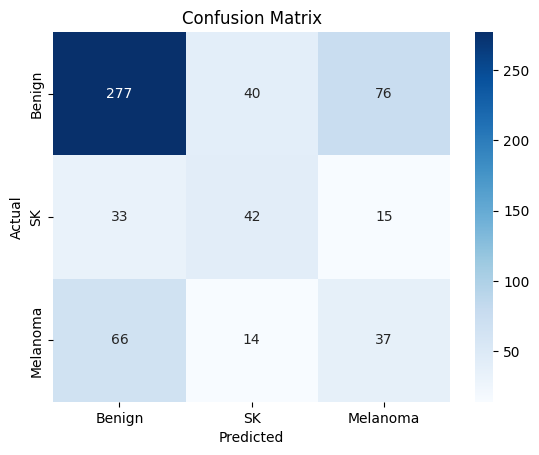


Sensitivity and Specificity per class:
Class: Benign
  Sensitivity: 0.7048
  Specificity: 0.5217
Class: SK
  Sensitivity: 0.4667
  Specificity: 0.8941
Class: Melanoma
  Sensitivity: 0.3162
  Specificity: 0.8116

AUC (macro): 0.7208
AUC (micro): 0.7851
AUC (weighted): 0.7040
Balanced Accuracy (BACC): 0.4959


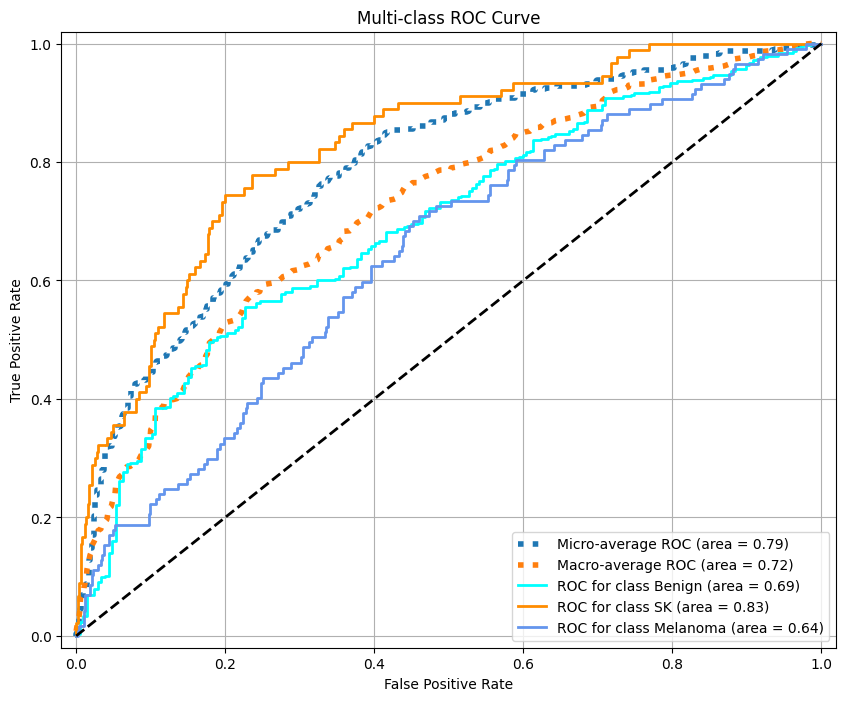

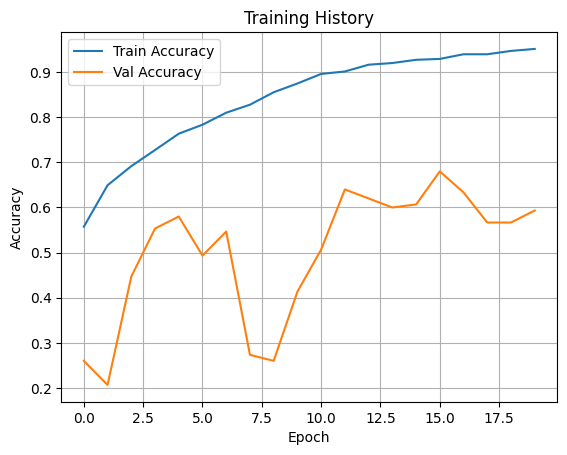

In [ ]:
#run the pipeline
main()